In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/1080340/train_dataset_mincult-train.zip

--2024-04-13 07:31:54--  https://lodmedia.hb.bizmrg.com/case_files/1080340/train_dataset_mincult-train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 95.163.53.117
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9924188152 (9.2G) [application/zip]
Saving to: ‘train_dataset_mincult-train.zip’

train_dataset_mincu 100%[===================>]   9.24G  10.5MB/s    in 15m 43s 

2024-04-13 07:47:40 (10.0 MB/s) - ‘train_dataset_mincult-train.zip’ saved [9924188152/9924188152]



In [ ]:
import pandas as pd

df = pd.read_csv('train.csv', sep=';')  # Весь датасет

## Загрузка вит

In [ ]:
%pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import torch
import numpy as np

# Загрузка ViT
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, output_hidden_states=True).cuda()


2024-04-13 18:48:19.898190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificat

## Простой индекс без ivf на всех (типа) изображениях

In [ ]:
import faiss

model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, output_hidden_states=True).cuda()


def get_embed(image):
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    image = image.resize((224, 224))

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(**inputs)

    return output.hidden_states[0].mean(dim=1)[0].cpu().numpy()

/home/jupyter/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from t

In [ ]:
from tqdm import tqdm


def get_embed_all():
    image_vectors = []
    for i in tqdm(range(df.shape[0])):
        img_dir = f"train/{df.iloc[i]['object_id']}/{df.iloc[i]['img_name']}"
        image_vectors.append(get_embed(Image.open(img_dir)))
    return image_vectors

In [ ]:
image_vectors = get_embed_all()

100%|██████████| 20345/20345 [27:13<00:00, 12.46it/s]  


#  Работающий индекс

In [ ]:
dim = image_vectors[0].shape[0]
num_components = 64
# создаем объект PCAMatrix
pca_matrix = faiss.PCAMatrix(dim, num_components)

image_vectors = np.array(image_vectors)
# обучаем PCAMatrix на исходных векторах
pca_matrix.train(image_vectors)

# применяем PCAMatrix для понижения размерности векторов
output_vectors = pca_matrix.apply_py(image_vectors)

index = faiss.IndexFlatL2(output_vectors[0].shape[0])

index.add(output_vectors)

In [ ]:
faiss.write_VectorTransform(pca_matrix, "PCA.pca")
faiss.write_index(index, "working.index")

In [ ]:
def find_simmilar_pca(image):
    index = faiss.read_index("working.index")
    PCA = faiss.read_VectorTransform("PCA.pca")
    query_image_vector = pca_matrix.apply_py(np.array([get_embed(image)]))

    k = 10
    distances, indices = index.search(query_image_vector, k)
    res = [df.iloc[i] for i in indices][0]
    return res

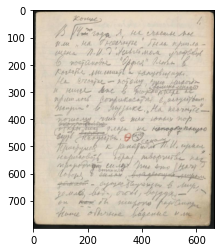

In [ ]:
import matplotlib.pyplot as plt


img_dir = f"train/{df.iloc[10]['object_id']}/{df.iloc[10]['img_name']}"
image = Image.open(img_dir)
plt.imshow(image)

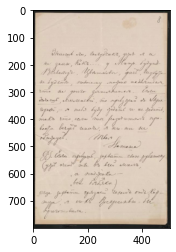

In [ ]:
res = find_simmilar_pca(image).iloc[2]
img_dir = f"train/{res['object_id']}/{res['img_name']}"
image = Image.open(img_dir)
plt.imshow(image)